# Wave propagation & waveform tomography

*Note: This practical is made for Earth Science Part II students in Cambridge. Assumptions about prior knowledge have been made accordingly.*

Previously, you have worked with the premise that earthquakes emit 'rays' of seismic signal, that travel along an infinitesimally narrow path from source to receiver. This *ray theory* stems from geometric optics, and has been an incredibly successful tool in determining the Earth's structure already in the early 20th century.

![darkside](img/pinkfloyd.png)

However, just like light, seismic energy propagates at many different wavelengths. Ray theory basically gets rid of all the *wave* aspects of seismic wave propagation. This simplification cannot reproduce all effects that we observe.

The main issue with this simplification is its inability to account for certain wave-like behaviour (e.g. diffraction, scattering) and effects like _dispersion_ (which lies a the base of the prism's effect in the image above), wave interference and so-called "wavefront healing".

*The above image is from the Pink Floyd album "Dark side of the moon"*

## This practical

In this practical, you will **explore the wave nature of seismic wave propagation**, as well as why this is relevant, and how we can use it in seismic imaging. You will do this by **running simulations of seismic wave propagation**. Note that this is computationally expensive for real-world applications but we have scaled this down for you. 

1. **First**, you will get familiar with the setup in which all the simulations in this practical will take place, and prepare all the necessary information to turn this setting into something the computer can run simulations with.
1. **Second**, you will simulate seismic waves propagating through this setup and analyse what is happening. You will become familiar with the interplay between source-receiver configuration, the seismic wavefield and reflections.
1. **Third**, you will learn about the relationships between seismic velocity, signal frequency and the ray approximation. For this, you will look at _Fresnel zones_ and compute so-called _sensitivity kernels_. You will look at how this sensitivity varies for different parts of the seismogram and analyse how they highlight different properties and/or parts of the model.

At the end, **you should be able to answer the following questions**:

* What are the main assumptions of ray theory? And where does this assumption break down?
* What do we mean by  'sensitivity kernels', and how do they relate to ray paths?
* What information is stored in a seismogram about different parts of our domain?
* Under what circumstances do the assumptions of ray theory hold best?
* What is the influence of frequency on sensitivity to a model?

In this practical you will do exercises and answer questions, all of which are supplied and can be carried out in this _Jupyter notebook_. 

<div class="alert alert-block alert-info">
<b>Note</b>: 
In order to carry out this practical and answer the questions, you will have to run all the <i>notebook cells</i> (the boxes with text and code). Running a cell is done by pressing `Ctrl+Enter`; running a cell and moving to the next one with `Shift+Enter`.
    
If you would like to answer the questions within this notebook, then you can create a new cell by pressing the "+" in the menu  bar above. Changing the cell type between text (Markdown) and code (Code) is done in the dropdown box in the same menu bar.
</div>

# Seismic signals under the surface

## Preliminary: Ray paths

Consider the following halfspace beneath a surface (2-D). Assume that seismic velocities are constant throughout it, but that P- and S-wave velocities are different, just as in natural rock. We're taking horizontal (left to right) = x and vertical (downwards) = z. At 40 km below the surface, we are placing a seismic point source (on the left) and a receiver (100 km to the right of it).

<img src="img/geometry_halfspace.png" width="600" align="center" />

* **Question 1**: Which waves go faster? P- or S-waves?

* **Question 2**: In the setting depicted in the diagram above, which are all the paths along which signal can travel from source to receiver? For the purpose of this question draw schematic ray paths (i.e. assume ray theory). _Hint: when considering reflections, think of Snell's law:_

$$ \frac{\text{sin}(\theta_1)}{v_1} = \frac{\text{sin}(\theta_2)}{v_2} $$

## A seismogram

Now suppose that the source emits a brief vibration in the x direction (top plot). As a result of this, several distinct vibrations, or _arrivals_ are recorded at the receiver (bottom plot):

![source-time-function](img/stf_37.5.time_only.png)

![seismogram](img/seismogram_srcx.png)

* **Question 3**: How do the different arrivals that we see on this seismogram relate to the different paths that you drew in Question 2? How can comparing the two seismogram components (X and Z) help you in this?  
_This question can be answered using only qualitative insight building from your answers above. However, if you want to make this a bit more quantitative, you can assume that P velocity = 5.8 km/s and S velocity = 3.2 km/s. Please don't overthink this._

## Simulating wave propagation

Below, you will run simulations of wave propagation, and interpret the results. This is done using a Python code that we've written for this purpose -- supplied in the directory where this Jupyter notebook is also located. We'll go through building up such a simulation step-by-step, such that you get an idea of how it works.

Below is the first cell you will run. It _imports_ some code such that we can make use of its functionality. Part of this is from well-known public libraries (e.g. NumPy), part of it is specific to our wave propagation project.

In [1]:
# first imports

import numpy as np                    # maths toolbox
import matplotlib.pyplot as plt       # plotting toolbox

from WavePyClasses import Grid, HomogeneousModel, Source, Receiver

### Making a model box

Because computers are not very good at dealing with infinity, we'll have to transform our (semi-infinite) halfspace to a finite box in which the simulations are carried out. Let's say we take a box of 200 km wide by 100 km deep, which should be sufficient for our setup. In order to run the simulations, we'll be *discretising* the model into a grid with a spacing of 400 m.

<div class="alert alert-block alert-info">
<b>Note</b>: How the grid is set up (i.e. which grid spacing `dx` and `dz` to choose) is motivated by the physics and how the simulations work -- to be precise the source frequency. We'll not go into this here due to time constraints of this practical.
</div>

<div class="alert alert-block alert-warning">
<b>SI units</b><br>

Because we're now calculating physics, we are going to stick entirely to SI units. That means that all units you're supplying to the program will be in metres, seconds, kilograms, metres per seconds, etc. 
</br>
</div>


In [2]:
# Setting up the model domain:

Lx = 200e3 # horizontal length of the model in metres
Lz = 100e3 # vertical depth of the model in metres

dx = 400.  # horizontal grid spacing [m]
dz = 400.  # vertical grid spacing [m]

grid = Grid(Lx, Lz, dx, dz)

grid.print_params()

Grid properties:
 Lx, Lz = 200000.00, 100000.00 m
 nx, nz = 501, 251
 dx, dz = 400.00, 400.00 m


### Making the model

* **Task**: Within the modelling domain, define the following properties:
    * density = 2600 kg/m$^3$
    * P velocity = 5.8 km/s 
    * S velocity = 3.2 km/s 

**Careful**: Make sure you fill it in in **SI units**. It may appear childish to make you go through this, but it's a useful exercise -- errors with units have felled the best of scientists (notably resulting in a [very expensive mishap](https://en.wikipedia.org/wiki/Mars_Climate_Orbiter) with a $125 million dollar Mars orbiter in 1999).

In [3]:
# make model

rho =  # density in kg/m^3 
vp  =  # P velocity in m/s
vs  =  # S velocity in m/s

# make a model out of the supplied values
model = HomogeneousModel(grid, rho=rho, vp=vp, vs=vs)

SyntaxError: invalid syntax (<ipython-input-3-9b8fe05d76bf>, line 3)

<div class="alert alert-block alert-info">
<b>Note</b>: The wave equation is defined using the elastic parameters $\mu$ and $\lambda$ rather than $v_s$ and $v_p$. Therefore, when we make our model, our values $v_p$ and $v_s$ are transformed to $\mu$ and $\lambda$ under the hood, according to 
$ v_p = \sqrt{\frac{\lambda + 2\mu}{\rho}} $ and
$ v_s = \sqrt{\frac{\mu}{\rho}} $.
    
</div>

### Defining the source and receiver

Now we're going to put a source and a receiver in the model, in the same locations as in our sketch above. 

In [4]:
# define source and rec

src = Source(
    loc_x=50e3, loc_z=40e3
) 

rec = Receiver(
    loc_x=150e3, loc_z=40e3
)

print(src)
print(rec)

Source properties:
 location (x,z): 50000.00, 40000.00 m 

Receiver properties:
 location (x,z): 150000.00, 40000.00 m 



If we want anything interesting to happen, our source needs to emit some energy. We will define a _source time function_ for this, and give it a direction. Here, we will use a so-called "Ricker wavelet" as a source time function because it has a nice shape and a reasonably looking frequency spectrum.

*(Note: the frequency spectrum is relevant because the model discretisation depends on it)*

The Ricker wavelet looks like this:

![source-time-function](img/stf_shape.png)

We define our source time function as

$$ r(t) = (-2\,(2\tau_0/\tau)^3/\pi) \, (t-t_0) \; \text{exp} \left[-(2\,\tau_0/\tau)^2 \, (t-t_0)^2\right] $$

where:

* $t_0$: the point in time where the middle zero-crossing happens
* $\tau$: the source duration

Because our calculation is step by step, we'll have to define a time axis first. Let's say we want at first about 10 seconds of time. Furthermore, let's define the source to be excited in the X direction.

<div class="alert alert-block alert-info">
<b>Note</b>: Just like with the grid, the time step is not chosen randomly -- it is derived from the physics of wave propagation, the seismic velocities and the grid spacing chosen above.  Here, we just provide a suitable time step for you (dt = 0.03).
</div>

* **Task**: Fill in the source time function such that: 
    * The source amplitude only starts rising well after the beginning of the time (otherwise you will get strange numerical effects in your simulation)
    * The source duration is 4 seconds


Source properties:
 location (x,z): 50000.00, 40000.00 m 
 time: from 0.00 to 9.99 s (dt=0.03 s, 334 timesteps)
 source-time-function has been defined



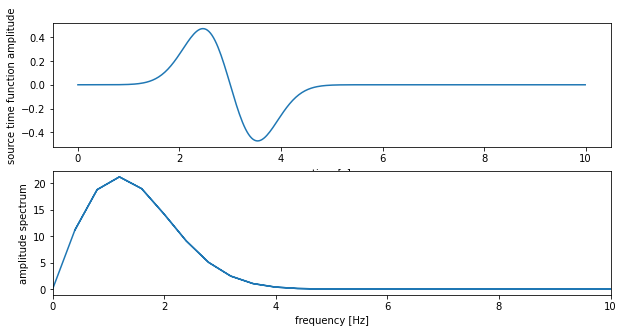

In [5]:
# define time axis and source-time function

simulation_duration = 10.
t_0 =
tau =

src.set_time(t_max=simulation_duration, dt=0.03)

src.set_stf(
    src_type='ricker',
    src_direction = (1,0), 
    t_0 = t_0,
    tau = tau,
)

print(src)

src.plot_stf()

### Running the simulation

Now that we have a discretised model, a source (with source-time function) and a receiver, we're finally getting to the interesting bit. To run the simulation, we'll first have to import the actual wave propagation simulation code.

In [6]:
import WaveProp as waveprop

Above, you defined a source time function of 10 seconds, so let's start off with running a pretty simple simulation based on this. 

<div class="alert alert-block alert-info">


<b>Using the function `run_waveprop`</b> 
<p>
The function that actually does the wave simulation is called `run_waveprop` and needs a bit of input. First of all, it requires your source(s), receiver(s) and model. Furthermore:</p>

<ul>
        <li><b>Plotting the wavefield</b>: 
            The code can show you the wavefield as it is developing by setting the `plot_wavefield` option to `True`. `plot_wavefield_every` defines every how many time steps this is done. It's hard work for your computer to plot this, so every time step would just take ages. Depending on the time step and duration of the simulation, a value between 10 and 50 is usually suitable.
</li>
        <li><b>Verbosity</b>: We're also setting the `verbose` option to `True`, such that it gives us a little bit of feedback on what's happening under the hood.
</li>
</ul>

The variable `receivers` is output of the simulation, while you also supplied a receiver as input. `receivers` is a list of all receivers you supplied (there may be more than one), with each of them having a new attribute `.seismogram`. 

</div>

<div class="alert alert-block alert-info">

<b>A note on visualisation in jupyter notebooks</b> <br>
    In order to actually see what happens <i>during</i> a simulation, you need to start the cell with the line

    `%matplotlib notebook` 

above it. Then the plot becomes interactive (and will update itself while the code is running). For most plots it's not necessary (and it is an annoying feature if you don't need it) so you can turn it off again by setting at the beginning of a cell

    `%matplotlib inline`
    
</div>

Simulation mode: forward
Lx, Lz   = 200000.0, 100000.0
dx, dz    = 400.0, 400.0 m
nx, nz    = 501, 251
timestep  = 0.03 s
duration  = 10.0 s
timesteps = 334 (running from 0 to 333)
plotting the wavefield


<IPython.core.display.Javascript object>


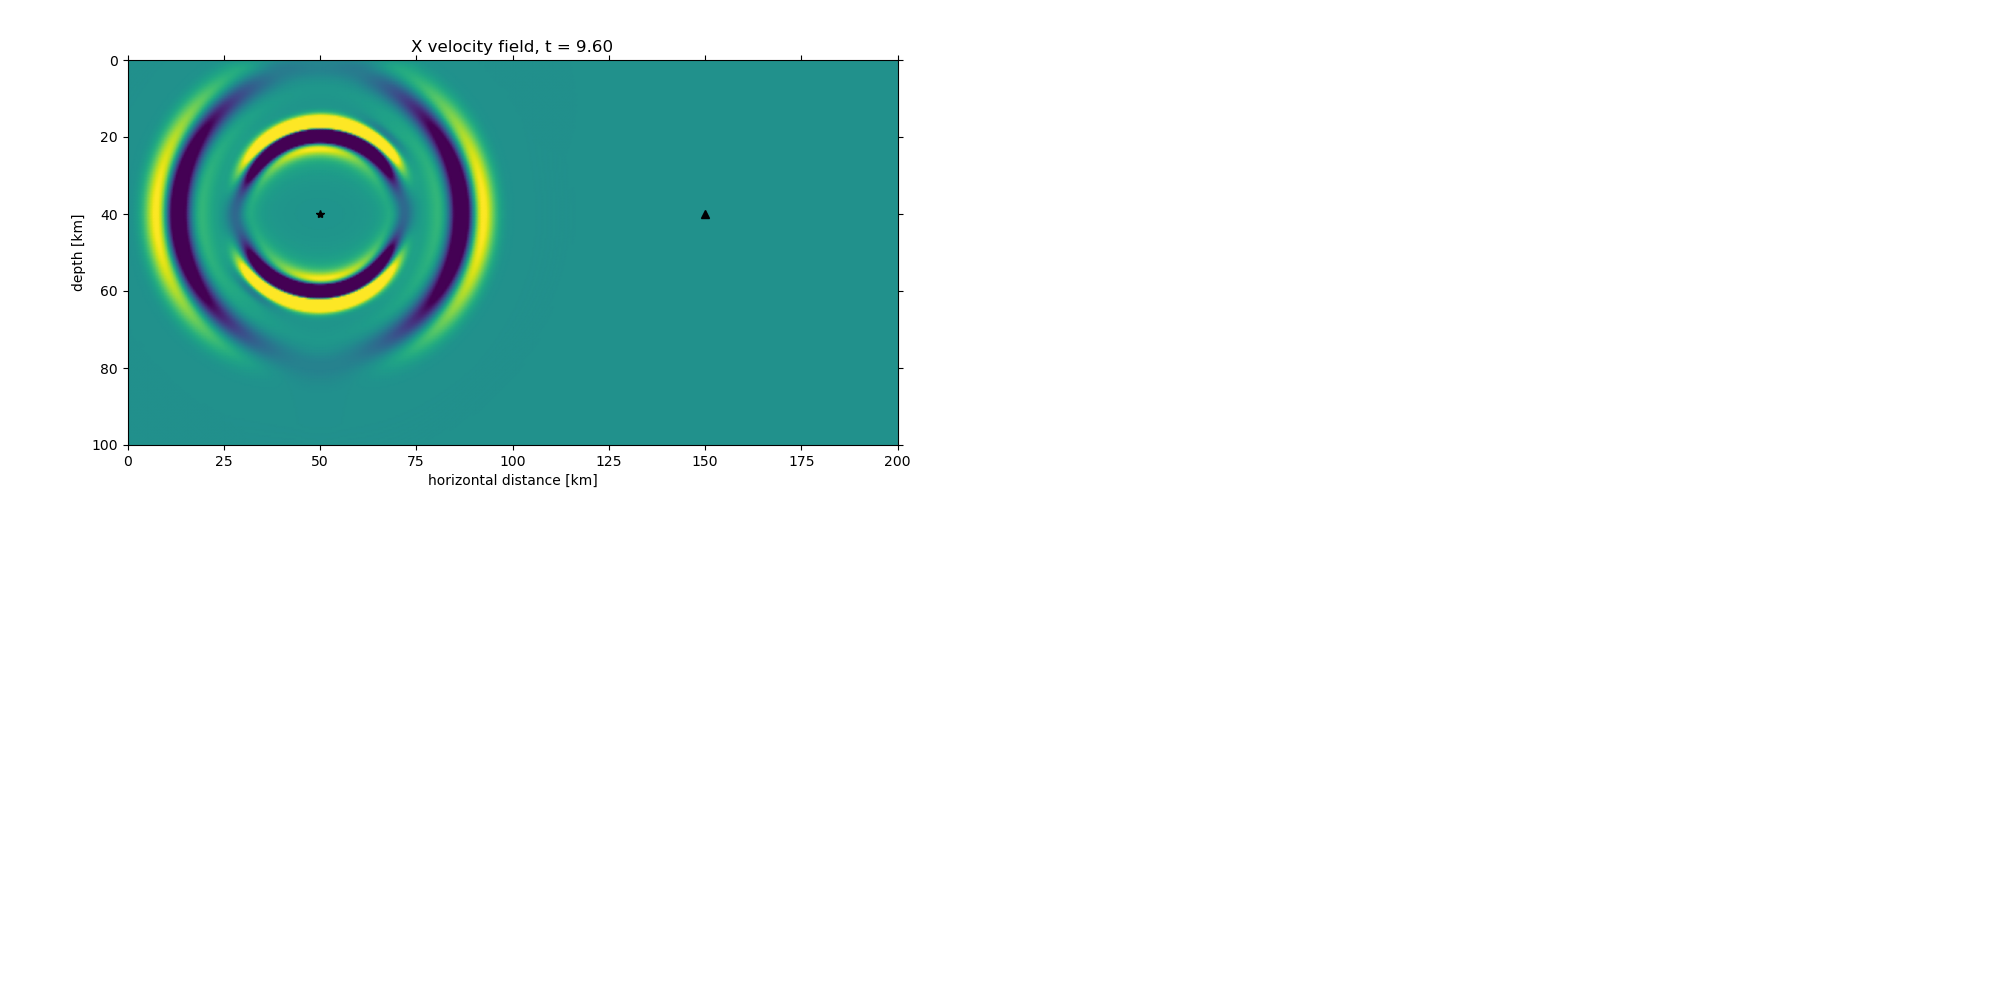

final timestep is 9.99 (number 333)


<IPython.core.display.Javascript object>


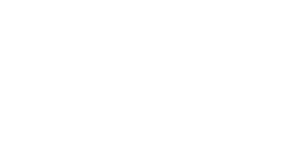

In [7]:
%matplotlib notebook
plt.close()
receivers = waveprop.run_waveprop(src, rec, model, 
                            plot_wavefield=True, 
                            plot_wavefield_every=40, 
                            verbose=True);
plt.show();

* **Question 4**: Discuss what you observed in this very short simulation. What kind of signals do you see? How does this relate to the source that you defined? And what would happen if you had changed the `source_direction` to (0,1)? *No need to actually run a new simulation for this -- just think about what might happen.*
* **Question 5**: What do you expect will happen to the waves when you run the simulation for longer? What will happen when the waves reach the boundaries of our non-infinite model box?

### A bit longer

We will now run the simulation for a bit longer, and actually see what happens.

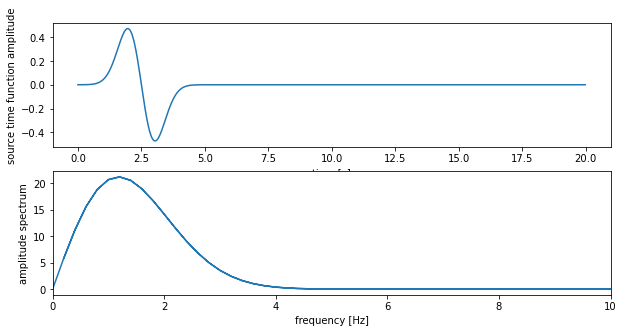

In [8]:
%matplotlib inline

simulation_duration = 20.

src.set_time(t_max=simulation_duration, dt=0.03)
src.set_stf(
    src_type='ricker',
    src_direction = (1,0),
    t_0 = 2.5,
    tau = 4,
)

# plot the source and its spectrum
src.plot_stf()

In [ ]:
%matplotlib notebook
plt.close()
receivers_out = waveprop.run_waveprop(
    src, rec, model, 
    plot_wavefield=True, 
    plot_wavefield_every=40,
    verbose=True)
plt.show()

**Well, that looks messy.**

Here we run into the limitation of simulating wave propagation: we've defined it in a box, whereas we're interested in a halfspace. And guess what:

### A box is not a halfspace
In the simulation above, we ran into reflections from every direction, most notably also the sides and the bottom. To simulate the "infinity" of the left, right and bottom boundaries, we will introduce so-called "absorbing boundaries" or "sponge layers". The method we use was developed in the 1990s in order to bypass the need to make the model ever larger, ensuring that our waves never reach the box edge. This method is not perfect, but it gets rid of the unwanted reflections to a large extent.

![model_absbound](img/model_setting.png)

* **Task**: To give your model a bit of padding, define absorbing boundaries of 25 km width below. Then, run the simulation again, now including the absorbing boundaries. **Think of SI units.**

<div class="alert alert-block alert-info">
<b>Note</b>: again, this value is actually also motivated by physics.
</div>

In [ ]:
# put all the absorbing boundary info into a Python dictionary
absorbing_boundaries = {'left': ,
                        'right': ,
                        'bottom': ,
                       }

In [ ]:
%matplotlib notebook
plt.close()
receivers_out = waveprop.run_waveprop(src, rec, model, absorbing_boundaries, 
                            plot_wavefield=True, plot_wavefield_every=40,
                            verbose=True)
plt.show()

* **Question 6**: You should now see reflections only (*) from the top surface of the model domain. Identify all the different waves and reflections that you now see. Are they P or S? Why do you get double reflections?

_(*) apart from some very faint ones from the other boundaries, if you look very carefully. As said, the method is not perfect._

## From source to receiver

You should have developed some intuition of wave propagation now, and know how to set up a simulation. 

Now, let's run the simulation all the way to the receiver. For this, we'll again increase the duration of the source time function, in order for the signal to actually reach the receiver. After this, we can look at seismograms.

In [ ]:
%matplotlib inline

simulation_duration = 27.

src_fulltime = Source(
    loc_x=50e3, loc_z=40e3,
    t_max = simulation_duration,
    dt = 0.03,
    src_type = 'ricker',
    src_direction = (1,0),
    t_0 = 2.5,
    tau = 4,
) 

# plot the source and its spectrum
src_fulltime.plot_stf()

<div class="alert alert-block alert-info">
<b>Note</b>: We will also store the forward field by setting `store_forward_field = True` (this will be useful for the next part of the practical).
</div>

In [ ]:
%matplotlib notebook

# run the wave propagation
receivers, fw_fields = waveprop.run_waveprop(
    src_fulltime, rec, model, absorbing_boundaries, 
    plot_wavefield=True, plot_wavefield_every=40,
    store_forward_fields=True,
    verbose=True
)

plt.show()

Now that some signal has reached the receiver, we can check out the seismogram.

In [ ]:
%matplotlib inline
receivers[0].plot_seismogram()

* **Question 7**: having looked at the wave simulation, it should now be easy for you to determine which waves we see arriving. Compare to the seismogram at the beginning of this practical, and indicate the different arrivals. If necessary, rerun the wave propagation, making note of the arrival times that you're interested in.

# Interference

The effects of *interference* play an important role in the wave propagation we see. Suppose we have some energy travelling along a straight path from point A to point B, but at the same time some energy travelling along a slightly longer path:

![path](img/raypaths.png)

Because one signal travels along a slightly longer path, the signals arrive slightly shifted in time. As long as the path is only slightly shorter, this will result in _constructive interference_:

![timeshift](img/interference.png)

* **Question 8**: What is the maximum time shift that the wave can be delayed by to get constructive interference? You can imagine that if a maximum of one wave and a minimum of the next overlap, the result is zero (_destructive interference_). Visualise this by considering two simple sine waves.

* **Bonus task:** Derive above expression in terms of the wave period $T$. Consequently, what is the maximum deviation in path length in order for constructive interference to still occur, expressed in terms of wave period $T$ and wavespeed $v$?

With this maximum deviation in path length, we can describe an ellipse within which, to first order, energy will contribute to positive interference. This ellipse is called the _Fresnel zone_, the width of which is given by 
$$ w_F = \sqrt{\frac{v L}{f}}$$
with $v$ the wavespeed, $L$ the propagation distance, and $f$ the signal frequency. 

Here is an example of the Fresnel zone for a P-wave with a frequency of 2 Hz. Waves travelling within this entire region will interfere constructively with each other: 

![path](img/Fresnel_Pwave_2Hz.png)

**The Fresnel zone can be seen as the space around the source and receiver that will affect a signal, for a given combination of source, receiver and frequency content.** This is an important concept in wireless communication as well: if an object blocks part of the Fresnel zone, this can deteriorate the signal significantly even if it doesn't block the direct source-receiver path. Use this as some practical knowledge the next time you're waving around your phone to catch reception...

* **Question 9**: What happens to the Fresnel zone if we make our emitted energy signal longer-period?
* **Question 10**: What would the Fresnel zone look like for an S-wave, same source-receiver distance and same signal frequency?

## Sensitivity kernels

Very simply put, **sensitivity kernels are a generalised and mathematically more formal equivalent of the Fresnel zone**. You can equally see them as the generalised equivalent to seismic rays. It doesn't only work for direct waves, but for arbitrarily complex waves as well as *interfering* waves.

* The sensitivity kernel depends on the part of the data that you select: the _measurement_. Often we will select a specific arrival in our data. The sensitivity kernel corresponds to the part of the model that this seismic wave travelled through. If this is a direct path, it will look like a Fresnel zone. 
* If there are reflections, there is strong heterogeneity in your model, or you select multiple arrivals (whether interfering or not), the sensitivity kernel can get arbitrarily complicated.
* A specific measurement will have at least _some_ sensitivity to each of the model parameters $v_s$, $v_p$ and $\rho$. In other words, even if you select a P-wave, there will be some sensitivity to S velocity structure (and to density).

**In the next part, you will do this data selection yourself and create some sensitivity kernels.**

<div class="alert alert-block alert-info">
<b>Constructing sensitivity kernels</b><br>
    
Computationally, sensitivity kernels can be constructed by running two simulations: one forward and one 'time-reversed' or 'adjoint'. You will see in a minute what that means but in a nutshell, the adjoint method is just a convenient and computationally feasible way of computing sensitivity kernels. Without going into too much mathematical detail, here is how we construct them:
<ol>
    <li>Run a simulation where you store the wavefield (what you've just done). This is termed the <i>forward wavefield</i>. </li>
    <li>Make a measurement on the seismogram recorded at the receiver. This will be your <i>adjoint source</i>. </li>
    <li>Run a simulation that goes backwards in time, using this adjoint source that is emitted from the receiver position. This is the <i>adjoint simulation</i> which results in an <i>adjoint wavefield</i>. </li>
    <li>Calculate the interaction between the (stored) forward wavefield and the adjoint wavefield that is running. This interaction, summed over time, will add up to form the <i>sensitivity kernels</i>. </li>
</ol>
    
There is a sensitivity kernel for each model parameter, which results from different types of interactions between the forward and adjoint wavefields. Depending on what kind of signal was selected and what's inside your model, sensitivity to different parameters can look very different.    
</div>

## Make a measurement: P-wave

Because we already stored the forward wavefield in our previous simulation (step 1), we can now immediately move to step 2: making a measurement from the seismogram. This is done by selecting a specific window of interest from the seismogram. First of all, we will look at the direct P-wave arrival. Based on the wave propagation you ran, you should know which arrival this is on your seismogram.

Once we've decided which measurement we are focusing on, we can start computing sensitivity kernels. We do this by first calculating the adjoint source for the part of the seismogram that we're interested in.

* **Task**: From the seismogram that you plotted above, define a window around the direct P-wave arrival. For this, give the window start and end time in the cell below (`window_start` and `window_end`). Make sure that the window doesn't include any other arrivals (you may have to experiment with this a bit). If it does, you will see that the kernel will incorporate parts of the model that other phases are sensitive to.
* **Question 11**: Why did I supply the `component_of_window_selection = x`? 

If you run the cell below, a plot will appear showing both the original and windowed seismogram. If you change `plot=2` to `plot=3`, you will also see the resulting adjoint source. 

In [ ]:
# define the window pick

%matplotlib inline

component_of_window_selection = ['x']
# Fill in these values
window_start = 
window_end   = 

pick = {}
pick['component'] = component_of_window_selection
pick['times'] = [window_start, window_end]
print('window goes from {} to {} s'.format(pick['times'][0], pick['times'][1]))

receivers_Pwave = waveprop.make_adjoint_source(receivers, pick, plot=2)

We've now created a new `receivers_Pwave` variable that has an adjoint source attached to it, which is specific for the P-wave pick that we made. We can use this to run an adjoint simulation. Here, the recorded signal will travel from the receiver backwards in time towards the source, while simultaneously the stored forward field is loaded. Wherever the fields interact, the sensitivity kernel is built up. Having prepared this, we are now ready to run the wave propagation in adjoint mode. 

For this, we have some new input in the function:

* `simulation_mode = 'adjoint'` will tell the wave propagation to run backwards in time, and look for adjoint source time functions in the receiver dictionary rather than source time functions in the source dictionary.
* `forward_fields = fw_fields` are the forward fields that you've previously calculated.

Although this is a bit slower, we are going to plot the wavefield as it is developing again (`plot_wavefield=True`), so that you can see what is happening here. You will see that indeed the signal starts at the receiver, whilst time is counting backwards.

In [ ]:
%matplotlib notebook
plt.close()
kernels_Pwave = waveprop.run_waveprop(src_fulltime, receivers_Pwave, model, absorbing_boundaries,
                                simulation_mode='adjoint', forward_fields= fw_fields, 
                                plot_wavefield=True, plot_wavefield_every = 40, 
                                verbose = True)

Let's plot the kernels that have been built up. 

In [ ]:
%matplotlib inline
kernels_Pwave.plot_kernels(model=model, source=src_fulltime, receiver=rec)

* **Question 12**: Write down your main observations when looking at these kernels. What are the things you notice most? Use what you have learned in the preceding questions.

* **Bonus task**: If all went well, you picked your P-wave carefully and the sensitivity kernel looks clean: it only shows sensitivity in the elliptical area spanned by the source and the receiver. If you were not so careful, and would let the window run, for example, until $t$=27 s, your kernel would start to show sensitivity to parts of the model that the second arrival on your seismogram travels through. Explore below what this looks like and write down your main observations in how these kernels differ from your initial kernels.

In [ ]:
%matplotlib inline
component_of_window_selection = ['x']
window_start = 17.5
window_end   = 27.

pick = {}
pick['component'] = component_of_window_selection
pick['times'] = [window_start, window_end]
print('window goes from {} to {} s'.format(pick['times'][0], pick['times'][1]))

receivers_Pwave = waveprop.make_adjoint_source(receivers, pick, plot=2)

kernels_messyPwave = waveprop.run_waveprop(
    src_fulltime, receivers_Pwave, model, absorbing_boundaries,
    simulation_mode='adjoint', forward_fields= fw_fields, 
    plot_wavefield=False,
    verbose = True)

In [ ]:
%matplotlib inline
kernels_messyPwave.plot_kernels(model=model, source=src_fulltime, receiver=rec)

# S-wave

Now let's also compute a sensitivity kernel for an initial S-wave. For this, we have to change the source direction, and run the simulation a bit longer, because S-waves are slower.

In [ ]:
simulation_duration = 38.
t_0 = 2.5
tau = 4.

src_S = Source(
    loc_x=50e3, loc_z=40e3, 
    t_max=simulation_duration, dt=0.03, 
    src_direction=(0., 1.), # changed source direction
    src_type='ricker', tau=tau, t_0=t_0, 
)

In [ ]:
%matplotlib notebook

# run the wave propagation
receivers_Swave, fw_fields = waveprop.run_waveprop(src_S, rec, model, absorbing_boundaries, 
                                  plot_wavefield='vz', plot_wavefield_every=40,
                                  store_forward_fields=True,
                                  verbose=False)
plt.show();

In [ ]:
%matplotlib inline
receivers_Swave[0].plot_seismogram()

* **Question 13**: Compare this seismogram to the one you created for the initial P-wave simulation (i.e. the one with $\tau$ = 4 seconds). Can you find the same phases again? Identify all the separate arrivals you see. Which one is the direct S-wave? It may help to run the simulation several times with plotting turned on, and look at how the wavefield is developing.

Now, let's pick a window around the S-wave and create sensitivity kernels.

In [ ]:
%matplotlib inline

# define the window pick
component_of_window_selection = ['z'] # S-wave

# Fill in these values
window_start = 31.20 
window_end   = 35.

pick = {}
pick['component'] = component_of_window_selection
pick['times'] = [window_start, window_end]
print('window goes from {} to {} s'.format(pick['times'][0], pick['times'][1]))

receivers_Swave = waveprop.make_adjoint_source(receivers_Swave, pick, plot=2)

In [ ]:
kernels_Swave = waveprop.run_waveprop(
    src_S, receivers_Swave, model, absorbing_boundaries,
    simulation_mode='adjoint', forward_fields= fw_fields, 
    verbose = False
)

In [ ]:
kernels_Swave.plot_kernels(
    model=model, source=src_S, receiver=rec
)

* **Question 14**: Here, we see that the largest sensitivity is for S-velocity, in a path that goes in a straight line between source and receiver. However, these kernels aren't nearly as clean as the ones we created for the P-wave. Why is this kernel so much more messy than the P-wave kernel we looked at before? 

*Hint: go back to the seismogram where the measurement window is picked, and/or the wavefield simulation to see what happens around the time the S-wave reaches the receiver.*

# Sensitivity kernels and (waveform) tomography

The reason we are this interested in the wave nature of seismic wave propagation is that it is a direct issue in seismology. Earthquakes don't send out sharp pulses -- their source-time functions are extended over time. This means that in reality, ray paths in the Earth do not exist either - instead our signals are sensitive to a blob of Earth that gets ever more complex depending on the Earth structure.

Instead of seeing this as a limitation, **we can use the wave nature of seismic signals -- using waveform tomography**. Compared to 'classical' tomography, we do not measure specific arrival times and compare these to theoretically computed times, we compare entire seismograms against synthetic seismograms. In _waveform tomography_, we thus want to find an Earth model that fits our observed (entire) seismograms.

![path](img/Waveform_tomography_cartoon.png)

Sensitivity kernels play a central role in achieving this.

* By selecting windows that include arrivals that travelled along many different "paths" through the Earth, we can fill up our model with sensitivity. 
* Within each window, we compare our real and synthetic seismograms to each other to determine the "misfit", compute the adjoint source and from there calculate the sensitivity kernels.
* Sensitivity kernels, in this context, are the _gradients_ of the misfit with respect to the model parameters. In other words, they tell you how each model parameter should be updated in order to better fit the data.
* By doing this *iteratively* (compute misfit - compute gradients - update model - repeat), you can obtain an Earth model that reflects the full physics of seismic wave propagation, without needing any limiting assumptions.

## Why bother with these simulations?

The simulations that you've run here are very slow. If you want do waveform tomography on a large scale, with potentially hundreds of thousands of seismograms from hundreds of earthquakes, this will consume a lot of computational resources (and as a consequence, result in not insignificant greenhouse gas emissions). We therefore want to be sure that it's worth it. So is it? 

Your final task is a back-of-the-envelope calculation on the width of the sensitivity kernel within the Earth. For this, you will consider a typical type of signal that seismologists observe on seismograms in the medium to long distance range. Typically, at those distances the observed signal frequency is in the order of 1 Hz max.

* **Question 15**: Have a look again at the sensitivity kernels that you created. Indeed, they are to first order ellipses, reminiscent of the Fresnel zone that we already defined above: 
$$ w_F = \sqrt{\frac{v L}{f}}$$
with $v$ the wavespeed, $L$ the propagation distance, and $f$ the signal frequency. 
![path](img/Fresnel_on_kernel.png)
Assuming that our P-wave velocity defined at the beginning of this practical is representative for the entire Earth, and that 1 Hz is more or less the highest frequency that we can observe at large distances, what is the width of the Fresnel zone for a wave crossing the Earth? How do you expect the Fresnel zone/sensitivity kernel to change if we take into account the fact that seismic velocities within the Earth increase with depth? What does this mean for ray-based tomography?


* **Question 16**: explain in your own words what kind of advantages it may have to use waveform tomography rather than (ray-based) traveltime tomography. In which context would travel-time tomography be more suitable? What kind of signals do you need, then?